# Make figures for DF project

* Number fluctuation at different bacterial concentration
20, 40, 60, 80 and 100 n$_0$

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from myImageLib import dirrec, bestcolor, bpass, wowcolor
from skimage import io, measure
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
from scipy.signal import savgol_filter, medfilt
import os
from corrLib import corrS, corrI, divide_windows, distance_corr, corrIseq, readseq, match_hist
from scipy.signal import savgol_filter
from corrLib import boxsize_effect_spatial
import matplotlib as mpl
from numpy.polynomial.polynomial import polyvander
from scipy.optimize import curve_fit
from miscLib import label_slope
from corrLib import density_fluctuation
from scipy import signal

## Functions
* These functions will be collected in a library later

In [3]:
def readdata(folder):
    dataDirs = dirrec(folder, '*.csv')
    nameList = []
    dirList = []
    for dataDir in dataDirs:
        path, file = os.path.split(dataDir)
        name, ext = os.path.splitext(file)
        nameList.append(name)
        dirList.append(dataDir)
    fileList = pd.DataFrame()
    fileList = fileList.assign(Name=nameList, Dir=dirList)
    fileList.Name = fileList.Name.astype('int32')
    fileList = fileList.sort_values(by=['Name'])
    return fileList

In [4]:
def average_NF(folder, avrange=[250, 500]):
    l = readdata(folder)
    count = 0
    for num, i in l.iterrows():
        if i.Name < avrange[0] or i.Name > avrange[1]:
            continue
        tmp = pd.read_csv(i.Dir)
        if count == 0:
            data = tmp
        else:
            data += tmp
        count += 1
    return data / count

In [58]:
def corrlength(corrData, deg, fitting_range=1000):
    xx = np.array(corrData.R)
    yy = np.array(corrData.C)
    x = xx[xx<fitting_range]
    y = yy[xx<fitting_range]
    p = np.polyfit(x, y, deg)
    xsolve = np.linspace(0, x.max(), int(x.max()))
    yfit = np.dot(polyvander(xsolve, deg), np.flip(p).transpose())
    for xm, ym in zip(xsolve, yfit):
        if ym > (1 / np.e):
            continue
        else:
            return xm

## Figure implementations

#### Figure 1 - experiment
* Raw image from microscopy
* Spatial intensity variation

#### Figure 2 - GNF
* Deviation from CLT
* Slope vs. concentration

In [7]:
folders = [r'D:\Wei\Dynamics_raw\df_result\20',
           r'D:\Wei\Dynamics_raw\df_result\40',
           r'D:\Wei\Dynamics_raw\df_result\60',
           r'D:\Wei\Dynamics_raw\df_result\80',
           r'D:\Wei\Dynamics_raw\df_result\100']
data = pd.DataFrame()
for f in folders:
    a = average_NF(f, avrange=[400, 1000])
    name = int(os.path.split(f)[1])
    a = a.assign(Name=name)
    data = data.append(a)

Text(0, 0.5, '$\\Delta N/N^{0.5}$')

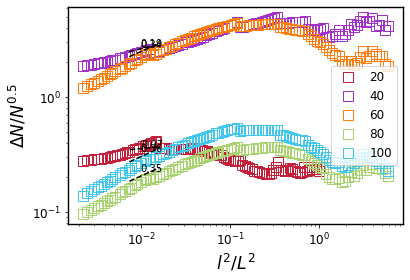

In [10]:
# GNF data
# Normalization of data is needed 
count = 0
slopeL = []
for name in data.Name.drop_duplicates():
    subdata = data.loc[data.Name==name]    
    # to plot, xx yy
    xx = subdata.n/420**2
    yy = subdata.d/subdata.n**.5       
    plt.plot(xx, yy, label=str(name), ls='', marker='s',
            mfc=(0,0,0,0), mec=wowcolor(count), markersize=10)
    # to fit
    x = xx.loc[subdata.n<1e4]
    y = yy.loc[subdata.n<1e4] 
    xf, yf, xt, yt, slope = label_slope(x, y, location='n')
    plt.plot(xf, yf, ls='--', color='black')
    plt.text(xt, yt, '{:.2f}'.format(slope))
    count += 1
    slopeL.append(slope)
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$l^2/L^2$')
plt.ylabel('$\Delta N/N^{0.5}$')

* Generate the data that are used in the plot

Text(0, 0.5, 'slope')

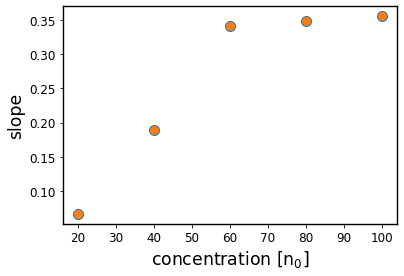

In [62]:
n = [20, 40, 60, 80, 100]
plt.plot(n, slopeL, ls='', marker='o', mfc=wowcolor(2),
        markersize=10, lw='2')
plt.xlabel('concentration [n$_0$]')
plt.ylabel('slope')

#### Figure 3 - intensity spatial correlation
* correlation vs. distance
* correlation length vs. concentration

In [28]:
# Average over 100 frames
folder = r'D:\Wei\Dynamics_raw\cl_result'
n = [20, 40, 60, 80, 100]
data = pd.DataFrame()
for nt in n:    
    subdata = average_NF(os.path.join(folder, str(nt)), avrange=[400, 1000])
    data = data.append(subdata.assign(conc=nt))

Text(0, 0.5, 'Correlation')

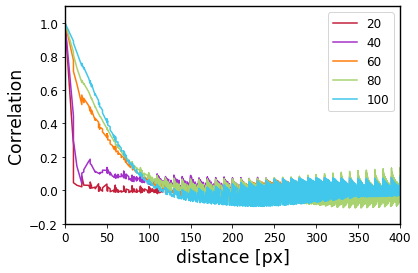

In [34]:
# Plot raw data
count = 0
for nt in data.conc.drop_duplicates():
    subdata = data.loc[data.conc==nt]
    plt.plot(subdata.R, subdata.C, color=wowcolor(count), label=str(nt))
    count += 1
plt.legend()
plt.axis([0, 400, -0.2, 1.1])
plt.xlabel('distance [px]')
plt.ylabel('Correlation')

Text(0, 0.5, 'Correlation')

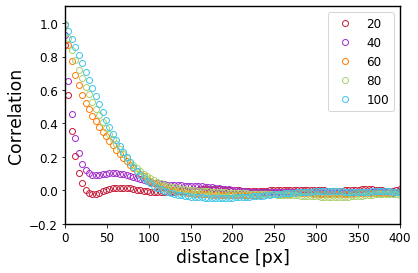

In [48]:
# Polynomial fitting in range
deg = 10 # degree of polynomial fitting
sparcity = 4 # how sparce the data lines are, larger value means less points
data = pd.read_csv(r'I:\Google Drive\Research projects\DF\Figures\fig3-spatialCorr\spatialCorr_crop.csv')

count = 0
for nt in data.conc.drop_duplicates():
    subdata = data.loc[data.conc==nt]
    x = subdata.R
    y = subdata.C
    p = np.polyfit(x, y, deg)
    xfit = np.linspace(0, x.max(), int(x.max()/sparcity))
    yfit = np.dot(polyvander(xfit, deg), np.flip(p).transpose())
    plt.plot(xfit, yfit, mec=wowcolor(count), label=str(nt), ls='',
            marker='o', mfc=(0,0,0,0))
    count += 1
plt.legend()
plt.axis([0, 400, -0.2, 1.1])
plt.xlabel('distance [px]')
plt.ylabel('Correlation')

Text(0, 0.5, 'correlation')

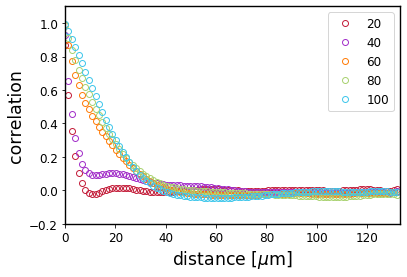

In [67]:
# Convert unit to um
deg = 10 # degree of polynomial fitting
sparcity = 4 # how sparce the data lines are, larger value means less points
data = pd.read_csv(r'I:\Google Drive\Research projects\DF\Figures\fig3-spatialCorr\spatialCorr_crop.csv')
mpp = 0.33

count = 0
for nt in data.conc.drop_duplicates():
    subdata = data.loc[data.conc==nt]
    x = subdata.R
    y = subdata.C
    p = np.polyfit(x, y, deg)
    xfit = np.linspace(0, x.max(), int(x.max()/sparcity))
    yfit = np.dot(polyvander(xfit, deg), np.flip(p).transpose())
    plt.plot(xfit*mpp, yfit, mec=wowcolor(count), label=str(nt), ls='',
            marker='o', mfc=(0,0,0,0))
    count += 1
plt.legend()
plt.axis([0, 133, -0.2, 1.1])
plt.xlabel('distance [$\mu$m]')
plt.ylabel('correlation')

Text(0, 0.5, 'correlation length [$\\mu$m]')

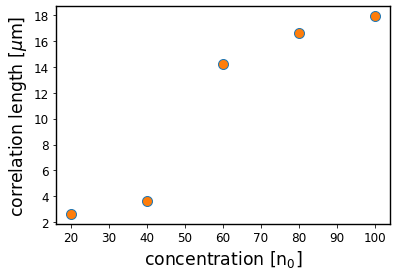

In [68]:
# Extract correlation length - based on polynomial fitting
deg = 8 # degree of polynomial fitting
sparcity = 1 # how sparce the data lines are, larger value means less points
data = pd.read_csv(r'I:\Google Drive\Research projects\DF\Figures\fig3-spatialCorr\spatialCorr_crop.csv')
mpp = 0.33

n = [20, 40, 60, 80, 100]
cl = []
for nt in data.conc.drop_duplicates():
    subdata = data.loc[data.conc==nt]
    cl.append(corrlength(subdata, 10))
plt.plot(n, np.array(cl)*mpp, ls='', marker='o', mfc=wowcolor(2),
        markersize=10, lw='2')
plt.xlabel('concentration [n$_0$]')
plt.ylabel('correlation length [$\mu$m]')

In [39]:
# Save data
# data.to_csv(r'I:\Google Drive\Research projects\DF\Figures\fig3-spatialCorr\spatialCorr_crop.csv', index=False)

#### Figure 4 - velocity and orientation spatial correlation
* velocity correlation 2D
* velocity correlation length vs. concentration
* orientation correlation 2D
* orientation correlation length vs. concentration

In [75]:
folder = r'D:\Wei\Dynamics_raw\piv_result\60'
pivData = pd.read_csv(os.path.join(folder, '900-901.csv'))
X = np.array(pivData.x).reshape((row, col))
Y = np.array(pivData.y).reshape((row, col))
U = np.array(pivData.u).reshape((row, col))
V = np.array(pivData.v).reshape((row, col))
CA, CV = corrS(X, Y, U, V)

In [72]:
col = len(pivData.x.drop_duplicates())
row = len(pivData.y.drop_duplicates())

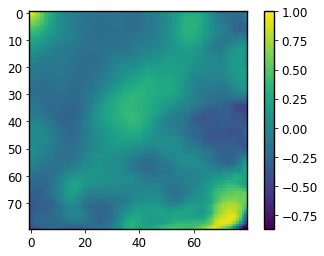

In [79]:
plt.imshow(CA)
plt.colorbar()

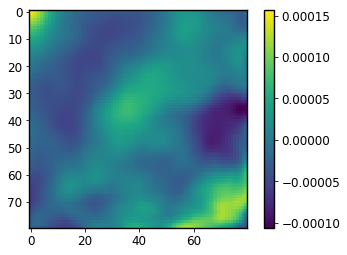

In [80]:
plt.imshow(CV)
plt.colorbar()

#### Figure 5 - what drives concentration fluctuations?
* concentration field $c$
* source field $\nabla \cdot (c\boldsymbol{n})$